We first run Canny edge detection [5] with threshold 0.2 on the image and group the resulting edge fragments into contours. If w is the diagonal length of a user’s annotation’s bounding box, we discard contours which are (1) shorter than 3% of w, because such contours tend to be texture not boundaries, (2) more than 5% of w away from the user
annotation, or (3) oriented more than 20 degrees away from the nearby user annotation. Finally, we find the boundary which has the most edge overlap and we assign a score to the user annotation in proportion to how much this best boundary was dilated or eroded.

In [1]:
from glob import glob

In [2]:
img_lst = glob("../web-app/app/static/COCO_*.png")

In [3]:
img_name = img_lst[0]

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [317]:
import cv2
img = cv2.imread(img_name,0)

In [6]:
edges = cv2.Canny(img,threshold1=100,threshold2=200)

In [19]:
cv2.Canny

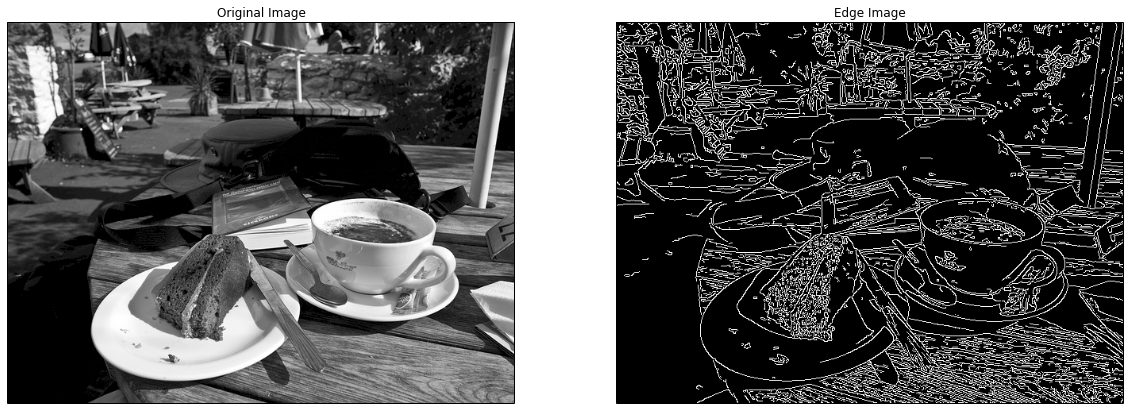

In [14]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image')
plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [16]:
edges

array([[  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ...,   0, 255,   0],
       ..., 
       [  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [18]:
np.where(edges!=0)

(array([  0,   0,   0, ..., 480, 480, 480]),
 array([ 14,  22,  27, ..., 613, 622, 636]))

In [ ]:
from analysis_toolbox import *

In [26]:

img_info,object_tbl,bb_info,hit_info=load_info()

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [40]:
oid = 8
obj = object_tbl[object_tbl["object_id"]==oid]
x_loc = int(obj["x_loc"])
y_loc = int(obj["y_loc"])

In [45]:
Ji = bb_info[bb_info["object_id"]==oid]

In [63]:
import ast

In [89]:
# Take the worker's average min and max to crop the image preprocessing for the Canny detection
worker_avrg_xmax = Ji.x_locs.apply(lambda x: np.array(ast.literal_eval(x)).max()).mean()
worker_avrg_xmin = Ji.x_locs.apply(lambda x: np.array(ast.literal_eval(x)).min()).mean()
worker_avrg_ymax = Ji.y_locs.apply(lambda x: np.array(ast.literal_eval(x)).max()).mean()
worker_avrg_ymin = Ji.y_locs.apply(lambda x: np.array(ast.literal_eval(x)).min()).mean()

In [90]:
dx = abs(worker_avrg_xmax-worker_avrg_xmin)/2.
dy = abs(worker_avrg_ymax-worker_avrg_ymin)/2.
print dx,dy

205.967499542 75.4149999619


In [91]:
print x_loc,y_loc

381 170


In [92]:
img = cv2.imread(img_name,0)
edges = cv2.Canny(img,threshold1=100,threshold2=200)

In [93]:
# dx = 100
# dy = 100
crop_img = img[y_loc-dy:y_loc+dy, x_loc-dx:x_loc+dx] 

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


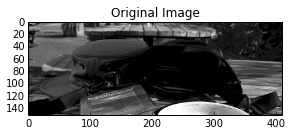

In [94]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(crop_img,cmap = 'gray')
plt.title('Original Image')

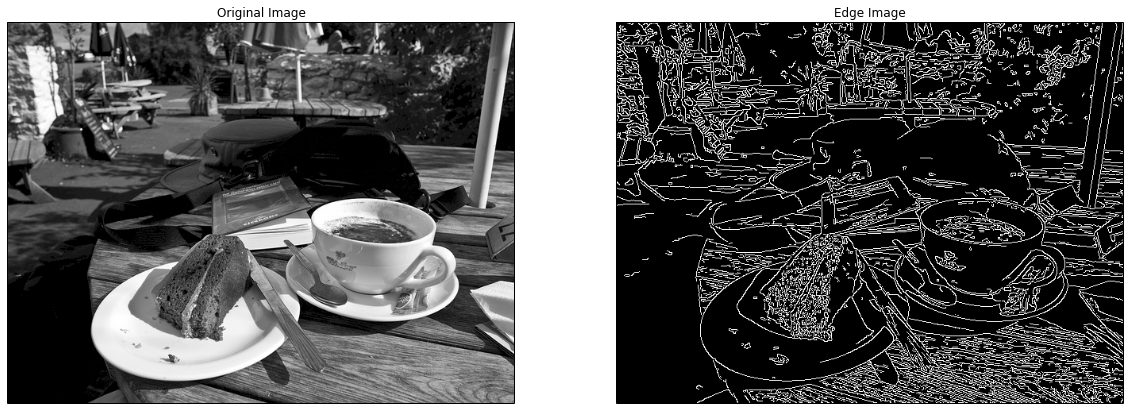

In [48]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image')

plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

actually, cropping with worker given is probably a bad idea because that mixes in worker data, lets try without first 

In [95]:
edges

array([[  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ...,   0, 255,   0],
       ..., 
       [  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

edges is just a matrix with non-edges as 0 and edge values as 255, so wecan just translate it into coordinates by using np.where, we don't have to regard these as connected entrities, when we discard contours we can just through away an "edge point" '

In [97]:
x_edges, y_edges = np.where(edges!=0)

In [98]:
print x_edges,y_edges

[  0   0   0 ..., 480 480 480] [ 14  22  27 ..., 613 622 636]


no I think we need contours afterall because we want connected boundaries and also because we want to compute various qualities associated with it like its length and stuff. contour is just a fancy word for closed loops. so we can get rid of disconnected lines 

In [192]:
im2, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [193]:
len(contours)

1825

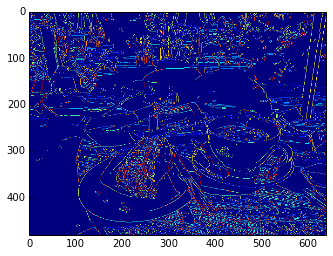

In [194]:
plt.imshow(im2)

In [ ]:
# w is the diagonal length of user's annotation box 


In [164]:
bb = Ji.ix[0]

In [157]:
# bb = zip(ast.literal_eval(bb["x_locs"]),ast.literal_eval(bb["y_locs"]))

In [122]:
from scipy.spatial import distance

In [167]:
bb_data = np.array([ast.literal_eval(bb["x_locs"]),ast.literal_eval(bb["y_locs"])])

In [171]:
shape(bb_data.T)

(45, 2)

In [173]:
allp2pDist = distance.pdist(bb_data.T)

In [178]:
len(allp2pDist)==45*(45/2) #this makes sense, length of the whole thing*half of itself (to avoid repeats)

True

In [179]:
np.where(allp2pDist==allp2pDist.max())

(array([153]),)

In [434]:
w = allp2pDist.max() #bounding box diameter = diagonal length of user BB

discard contours which are (1) shorter than 3% of w, because such contours tend to be texture not boundaries, (2) more than 5% of w away from the user
annotation, or (3) oriented more than 20 degrees away from the nearby user annotation. Finally, we find the boundary which has the most edge overlap and we assign a score to the user annotation in proportion to how much this best boundary was dilated or eroded.

In [440]:
#Filter out contours shorter than 3% of w 
# length_filtered_contours = filter(lambda x: len(x)>0.03*w,contours)
length_filtered_contours = filter(lambda x: cv2.arcLength(x,False)>0.03*w,contours)

In [432]:
w

292.58844816567859

In [437]:
bb_standard.boundary.length/2.

355.09104629798736

In [422]:
0.03*w

8.7776534449703565

In [418]:
len(contours)

1825

In [419]:
len(length_filtered_contours)

1071

In [421]:
cv2.arcLength(length_filtered_contours[0],False)

26.14213538169861

In [252]:
len(length_filtered_contours)

832

In [253]:
0.05*w

14.629422408283929

In [240]:
# this user annotation box is the "standard" that we compare all our contours against
bb_standard = [list(a) for a in zip(bb_data[0],bb_data[1])]

In [267]:
i=0
c = length_filtered_contours[i][:,0]

In [268]:
cx_lst ,cy_lst  = zip(*c)

In [269]:
bbx,bby = zip(*bb_standard)

In [272]:
obj_x_lst = [list(bbx),list(cx_lst)]
obj_y_lst = [list(bby),list(cy_lst)]

In [274]:
MunkresEuclidean(obj_x_lst,obj_y_lst)

16109.043230659883

In [241]:
distance.cdist(bb_standard,c[:,0])

array([[ 385.93393217,  386.74668712,  388.06829296,  388.57303046,
         388.16748962,  388.57303046,  388.06829296,  388.47908567,
         389.8025141 ,  390.63281992,  390.14356332,  390.56497539,
         390.14356332,  390.63281992,  389.8025141 ,  388.47908567,
         387.98195834,  388.47908567,  388.06829296,  386.74668712],
       [ 396.67619036,  397.65814464,  399.02130269,  399.39954932,
         398.90976423,  399.39954932,  399.02130269,  399.51595713,
         400.88028138,  401.87684681,  401.51338707,  402.01741256,
         401.51338707,  401.87684681,  400.88028138,  399.51595713,
         399.14533694,  399.51595713,  399.02130269,  397.65814464],
       [ 396.50472885,  397.53741962,  398.91101765,  399.24929555,
         398.73424734,  399.24929555,  398.91101765,  399.43084508,
         400.80543908,  401.85196279,  401.52833026,  402.05720986,
         401.52833026,  401.85196279,  400.80543908,  399.43084508,
         399.10023804,  399.43084508,  398.911

In [243]:
from qualityBaseline import *

In [208]:
[distance.pdist(c,bb_data) for c in length_filtered_contours]

ValueError: A 2-dimensional array must be passed.

In [189]:
bb_data

array([[302, 264, 254, 250, 250, 250, 248, 247, 247, 253, 267, 275, 290,
        312, 337, 353, 363, 411, 435, 449, 462, 470, 478, 480, 494, 503,
        511, 529, 532, 529, 522, 521, 516, 514, 506, 495, 493, 485, 483,
        468, 453, 428, 371, 358, 334],
       [124, 131, 137, 145, 152, 160, 167, 173, 188, 198, 201, 201, 205,
        207, 199, 198, 211, 227, 225, 223, 224, 222, 222, 214, 223, 224,
        227, 232, 223, 217, 212, 204, 192, 186, 173, 164, 158, 152, 144,
        140, 129, 126, 135, 122, 126]])

In [277]:
from shapely.geometry import Polygon, Point

In [289]:
# Example
poly = Polygon([(0, 0), (2,8), (14, 10), (6,1)])
point=Point(12,4)
dist=point.distance(poly)
print dist

2.49136439561


In [ ]:
10,6

In [295]:
sqrt(2**2+2**2)

2.8284271247461903

In [294]:
point.distance?

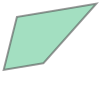

In [292]:
poly

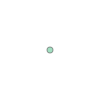

In [293]:
point

In [297]:
# this user annotation box is the "standard" that we compare all our contours against
bb_standard = Polygon([list(a) for a in zip(bb_data[0],bb_data[1])])

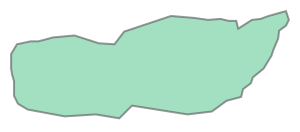

In [298]:
bb_standard

In [341]:
i=0
c = length_filtered_contours[i][:,0]

In [352]:
# d2BB contains a list of boolean for each point in the contour specifying whether the point is within w away from the BB
d2BB = [Point(xyloc).distance(bb_standard)<w for xyloc in c]

In [355]:
dist_length_filtered_contours = []
for contour in length_filtered_contours:
    # d2BB contains a list of boolean for each point in the contour specifying whether the point is within w away from the BB
    d2BB = [Point(xyloc).distance(bb_standard)<w for xyloc in contour[:,0]]
    unique_elements = list(set(d2BB))
    if len(unique_elements) ==1:
        if unique_elements[0]==True:
            #True only 
            dist_length_filtered_contours.append(contour)
    elif len(unique_elements) ==2:
        pass # contain at least one point that is more than w away from BB, so exclude this contour

In [356]:
print len(length_filtered_contours)
print len(dist_length_filtered_contours)

832
828


In [361]:
x,y = zip(*c[:,0])

In [428]:
def plotContour(img_name,contour_lst):
    img = plt.imread(img_name)
    plt.gca().invert_yaxis()
    plt.imshow(img,cmap= cm.Greys)
    for c in contour_lst:
        x,y = zip(*c[:,0])
        plt.plot(x,y,color='cyan',linewidth=0.5)
    dim = shape(img)
    plt.xlim(0,dim[1])
    plt.ylim(dim[0],0)

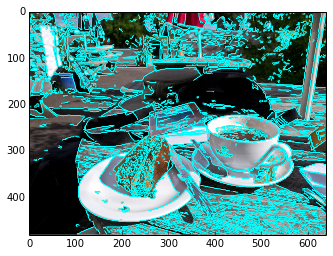

In [429]:
plotContour(img_name,contours)

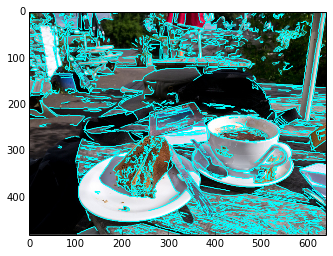

In [439]:
plotContour(img_name,length_filtered_contours)

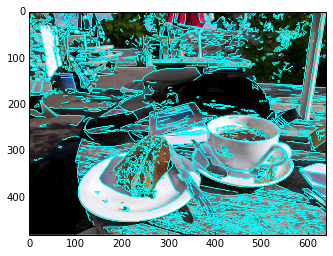

In [400]:
plotContour(img_name,dist_length_filtered_contours)

In [388]:
from matplotlib import cm